Hacer una introducción en donde ser explique sobre:
-	La base de datos que trabajaste
-	La fuente de información donde se extrajo
-	La temporalidad y geografía (la fecha de los delitos registrados en la base de datos si es anual, trimestral, mensual, etc. y la ubicación que supongo que es CDMX y que se tiene a nivel de alcaldía)
Comenzar con el análisis podrías decir si es que hubo alguna depuración en la base de datos y si hubo registros en blanco si es que aplicaron un método para tratar los vacíos.
Lo que veo que tienes 3 enfoques:
1.	Análisis por categoría de delito
2.	Análisis del número de delitos por alcaldía
3.	Análisis del número de delitos por mes y por año
Y con esos 3 enfoques hacer conclusiones sobre:
1.	Cual fue el tipo de delito que más se cometió sin distinguir la geografía
2.	Que alcaldías tiene una mayor inseguridad
3.	Y en que año y mes se tuvo el registro máximo de delitos 
Que los resultados están en las tablas que tienes en tu código 
Y con las gráficas se pueden hacer conclusiones mixtas:
1.	Que año y mes fue el que registro más delitos (sin distinción de categoría del delito)
2.	Que alcaldía fue más insegura en el año X y con el tipo de delito Y
3.	En que alcaldías se reportaron más delitos del tipo X en el mes Y del año Z
Algo así se me ocurre

# Reporte: Análisis de incidencia delictiva en la Ciudad de México mediante series de tiempo y análisis bayesiano

A continuación se expone lo realizado para la elaboración de la presente práctica, así como los resultados obtenidos.

## Sobre las fuentes de información

La información utilizada en el presente trabajo se obtuvo de tres fuentes:
* [Portal de datos de la Ciudad de México](https://datos.cdmx.gob.mx).
* [Instituto Nacional de Estadística y Geografía (INEGI)](https://www.inegi.org.mx).
* [Consejo Nacional de Población (CONAPO)](https://www.gob.mx/conapo).

## Sobre los datos

La información sobre los delitos denunciados se obtuvieron del portal de __[Datos Abiertos](https://datos.cdmx.gob.mx/explore/dataset/carpetas-de-investigacion-pgj-cdmx/export/)__ de la Ciudad de México, mientras que la información relativa al índice de marginación, y variables utilizadas para su construcción, se obtuvo del __[CONAPO](http://www.conapo.gob.mx/es/CONAPO/Datos_Abiertos_del_Indice_de_Marginacion)__. Por último la información referente al tamaño de la población fue consultada en el portal del __[INEGI](https://www.inegi.org.mx/programas/ccpv/2010/default.html#Tabulados)__.

Esta información está contenida en los archivos:
* [datos_delitos.rds](datos_delitos.rds). Contiene las denunias hechas por día desde enero de 2017 hasta junio de 2019.
* [Base_Indice_de_marginacion_municipal.csv](Base_Indice_de_marginacion_municipal.csv). Contiene el índice de marginación (_IM_) y algunas de las variables utlizadas para su construcción con información del CONAPO de 2015.
* [datos_pob.csvdatos_pob.csv](datos_pob.csv). Contiene información sobre el tamaño de la población de la Ciudad de México por alcaldía, incluye información desagregada por género.

## Alcance del proyecto

Usando los datos proporcionados por la Secretaría de Seguridad Ciudadana de la Ciudad de México, se realizó un análisis de series de tiempo para conocer el comportamiento, frecuencia y patrón de ocurrencia de delitos en la Ciudad de México. A través de este estudio se logró identificar los días en los que se reportan más delitos. Se observó la cantidad de delitos en cada una de las alcaldías de la Ciudad y se realizó un análisis de correlación entre la cantidad poblacional en cada alcaldía, el volumen de delitos reportados y el índice de marginación de cada alacaldía.

Adicionalmente, se realizó un análisis bayesiano que tiene por objetivo especificar la distribución del parámetro $\lambda$ si se asigna una distribución $Poisson$ al número de denuncias presentadas en cada alcaldía.

## Análisis descriptivo

Para el análisis descriptivo se requirió el paquete y configuraciones siguientes:

In [3]:
library(tidyverse)
options(digits=4, big.mark = ',', repr.plot.width=22, repr.plot.height=8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Finalmente se requirió cargar las base como se muestra a continuación:

In [4]:
marg_index <- read.csv('Base_Indice_de_marginacion_municipal.csv')

months <- c('January','February','March','April','May','June','July','August','September','October','November','December')

delitos <- readRDS('datos_delitos.rds') %>%
    mutate(categoria_delito = factor(categoria_delito),
           alcaldia_hechos = factor(alcaldia_hechos),
           año = factor(format(fecha_hechos,'%Y')),
           mes = factor(format(fecha_hechos,'%B'), level = months),
           CVE_MUN = case_when(
               alcaldia_hechos == 'ALVARO OBREGON' ~ 9010,
               alcaldia_hechos == 'AZCAPOTZALCO' ~ 9002,
               alcaldia_hechos == 'BENITO JUAREZ' ~ 9014,
               alcaldia_hechos == 'COYOACAN' ~ 9003,
               alcaldia_hechos == 'CUAJIMALPA DE MORELOS' ~ 9004,
               alcaldia_hechos == 'CUAUHTEMOC' ~ 9015,
               alcaldia_hechos == 'GUSTAVO A MADERO' ~ 9005,
               alcaldia_hechos == 'IZTACALCO' ~ 9006,
               alcaldia_hechos == 'IZTAPALAPA' ~ 9007,
               alcaldia_hechos == 'LA MAGDALENA CONTRERAS' ~ 9008,
               alcaldia_hechos == 'MIGUEL HIDALGO' ~ 9016,
               alcaldia_hechos == 'MILPA ALTA' ~ 9009,
               alcaldia_hechos == 'TLAHUAC' ~ 9011,
               alcaldia_hechos == 'TLALPAN' ~ 9012,
               alcaldia_hechos == 'VENUSTIANO CARRANZA' ~ 9017,
               alcaldia_hechos == 'XOCHIMILCO' ~ 9013)) %>%
    select(CVE_MUN, año, mes, alcaldia_hechos,categoria_delito)

Así, si se agrupan los datos por mes, año y alcaldía, se tendrán un total de $5,760$ observaciones mensuales, cuyo valor son las cantidades de denuncias realizadas al mes por año y por delegación, con lo cuál se puede obtener una tabla de cuántiles medias cómo se muestra a continuación.

In [18]:
(d.alc <- delitos %>%
    group_by(alcaldia_hechos, año, mes) %>%
    tally(sort = TRUE)) %>%
    with(sapply(split(n,alcaldia_hechos),summary)) %>%
    t() %>%
    format(digits = 2, big.mark = ',') %>%
    as.data.frame() %>%
    rownames_to_column(var = 'Alcaldía')

Alcaldía,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
ALVARO OBREGON,"1,031","1,168","1,276","1,256","1,351","1,472"
AZCAPOTZALCO,674,880,920,926,990,"1,069"
BENITO JUAREZ,"1,241","1,609","1,686","1,680","1,789","2,112"
COYOACAN,994,"1,176","1,278","1,261","1,357","1,491"
CUAJIMALPA DE MORELOS,207,247,266,265,279,330
CUAUHTEMOC,"2,148","2,782","3,039","2,967","3,177","3,513"
GUSTAVO A MADERO,"1,452","1,828","1,920","1,885","2,006","2,130"
IZTACALCO,646,763,840,834,908,"1,027"
IZTAPALAPA,"2,257","2,642","2,794","2,780","2,920","3,088"


Con su respectiva gráfica de boxplot:

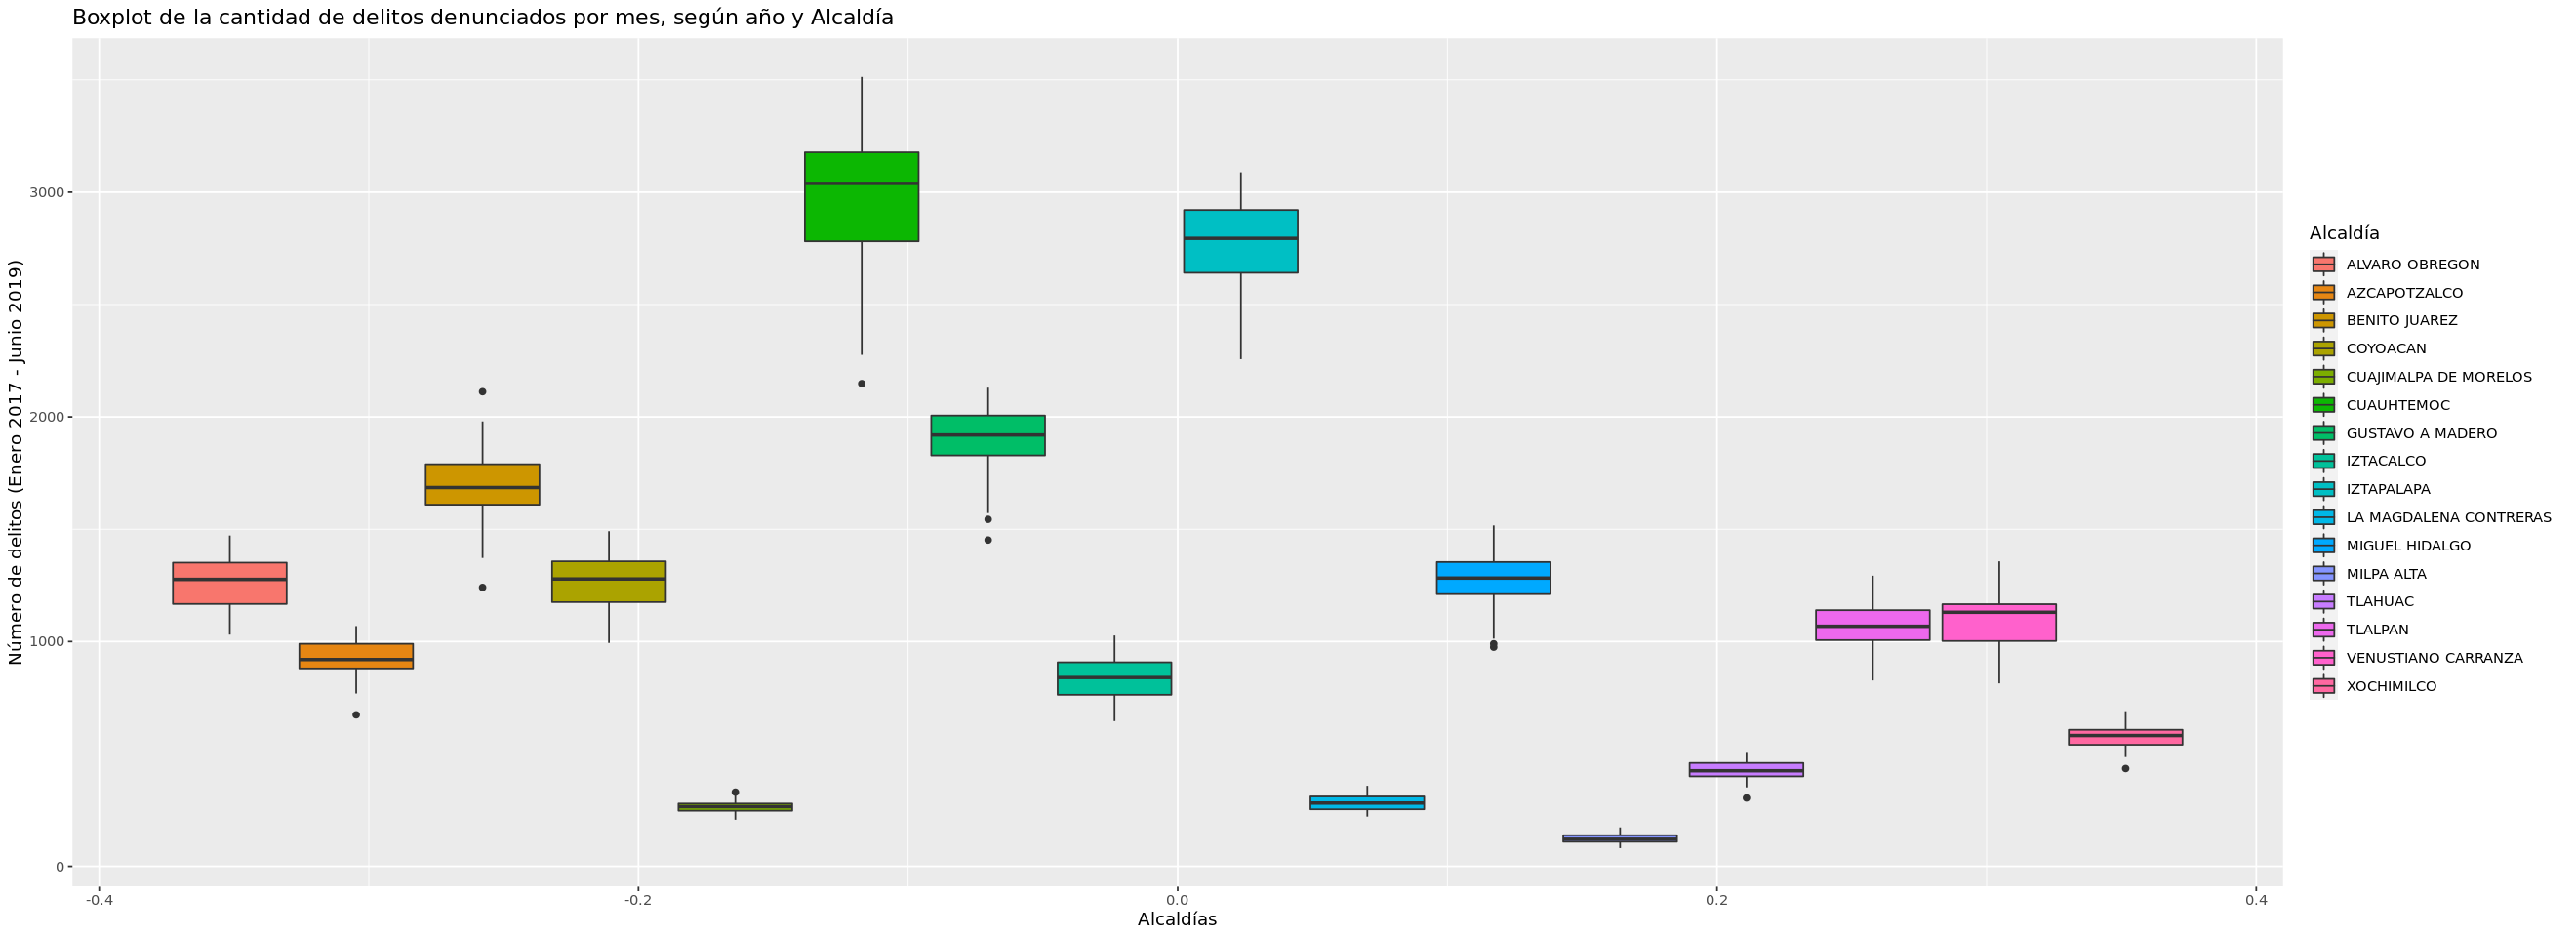

In [6]:
ggplot(d.alc,aes(n)) +
    geom_boxplot(aes(fill = alcaldia_hechos)) +
    coord_flip() +
    labs(x = 'Número de delitos (Enero 2017 - Junio 2019)',
         y = 'Alcaldías',
         title = 'Boxplot de la cantidad de delitos denunciados por mes, según año y Alcaldía',
         fill = 'Alcaldía')

Con lo cual se aprecia que alcaldías como _CUAUHTEMOC_, _GUSTAVO A MADERO_ e _IZTAPALAPA_ son las delegaciones con un mayor número de denuncias por mes, a su ves la alcaldía _CUAUHTEMOC_ es la alcaldía con un mayor rango intercuantil de $395$ denuncias. Por otro lado, alcaldías como _CUAJIMALPA DE MORELOS_, _LA MAGDALENA CONTRERAS_ y _MILPA ALTA_ son las de alcandías con un menor número de denuncias.

Por otro lado, si se reproduce el mismo análisis, pero en lugar de agrupar por alcaldías se agrupa por tipo de delito se obtiene lo siguiente:

In [19]:
(d.del <- delitos %>%
    group_by(categoria_delito, año, mes) %>%
    tally(sort = TRUE)) %>%
    with(sapply(split(n,categoria_delito),summary)) %>%
    t() %>%
    format(digits = 2, big.mark = ',') %>%
    as.data.frame() %>%
    rownames_to_column(var = 'Delito')

Delito,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
DELITO DE BAJO IMPACTO,"11,564.0","13,906.8","14,683.0","14,803.7","16,257.0","17,633.0"
HECHO NO DELICTIVO,236.0,555.0,"1,288.0","1,060.3","1,445.2","1,651.0"
HOMICIDIO DOLOSO,62.0,81.0,94.5,95.8,107.5,147.0
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,48.0,71.0,78.5,77.4,86.8,105.0
ROBO A CASA HABITACIÓN CON VIOLENCIA,28.0,34.2,39.0,43.9,49.8,76.0
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,11.0,24.5,30.5,33.5,39.8,61.0
ROBO A NEGOCIO CON VIOLENCIA,147.0,216.5,251.5,291.6,347.0,590.0
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,43.0,54.2,59.5,67.2,78.5,121.0
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,5.0,12.2,15.5,17.5,19.8,48.0


Con su respectiva gráfica de boxplot:

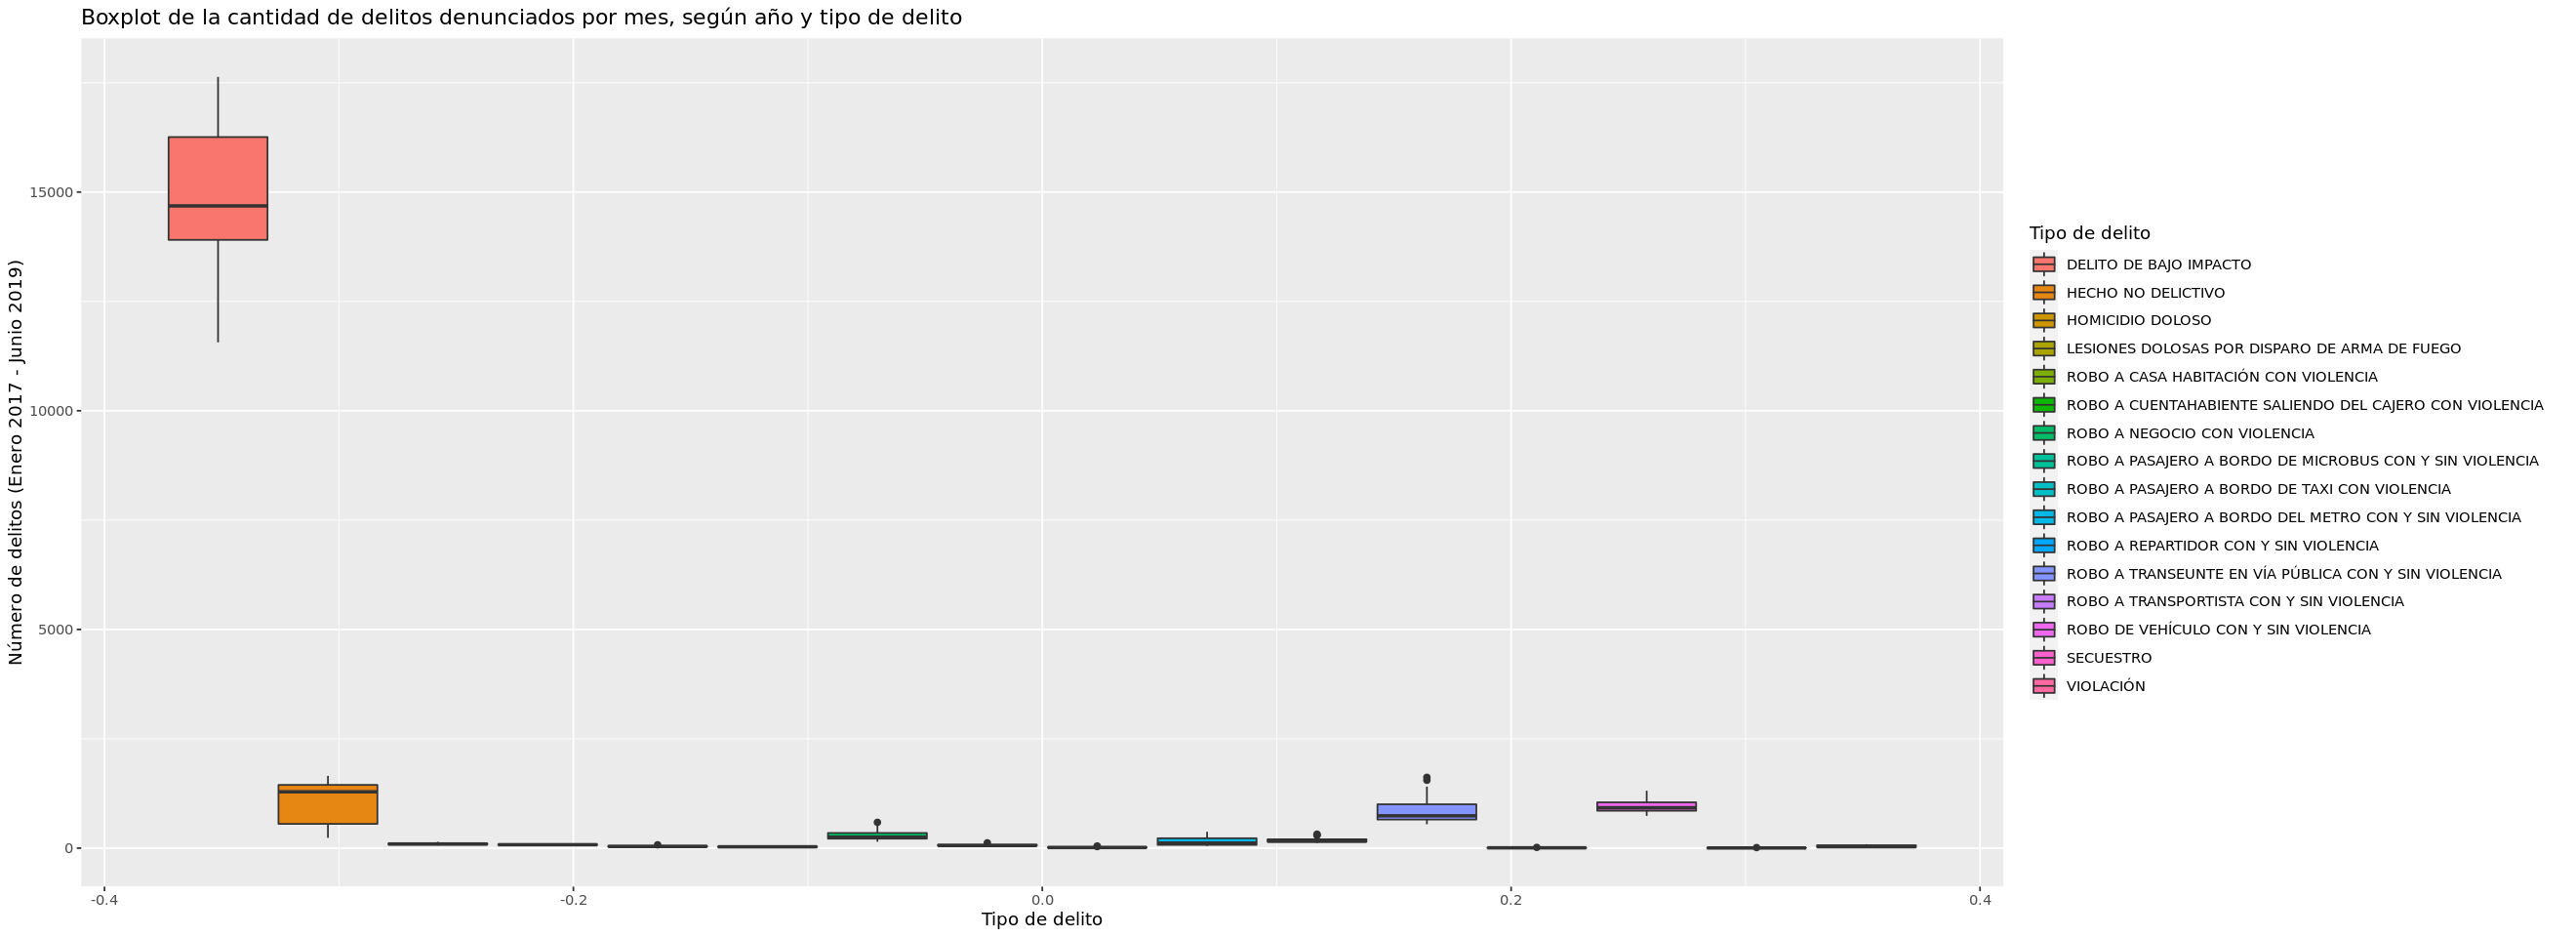

In [21]:
ggplot(d.del,aes(n)) +
    geom_boxplot(aes(fill = categoria_delito)) +
    coord_flip() +
    labs(x = 'Número de delitos (Enero 2017 - Junio 2019)',
         y = 'Tipo de delito',
         title = 'Boxplot de la cantidad de delitos denunciados por mes, según año y tipo de delito',
         fill = 'Tipo de delito')

Con lo anterior se aprecia que los delitos con un mayor número de denuncias son los que se catalogan como _DELITO DE BAJO IMPACTO_.

Por último se puede reproducir el análisis anterior si se consideran sólo mes y año.

In [22]:
(d.mes <- delitos %>%
    group_by(año, mes) %>%
    tally(sort = TRUE)) %>%
    with(sapply(split(n,mes),summary)) %>%
    t() %>%
    format(digits = 2, big.mark = ',') %>%
    as.data.frame() %>%
    rownames_to_column(var = 'Mes')

Mes,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
January,"15,045","15,822","16,598","16,678","17,494","18,391"
February,"15,643","17,125","18,607","17,636","18,632","18,658"
March,"17,761","18,892","20,022","19,313","20,088","20,155"
April,"16,448","17,260","18,071","18,109","18,940","19,808"
May,"18,897","18,912","18,927","19,691","20,088","21,248"
June,"15,239","16,890","18,542","17,876","19,194","19,847"
July,"18,402","18,818","19,234","19,234","19,651","20,067"
August,"19,226","19,582","19,938","19,938","20,294","20,650"
September,"18,104","18,505","18,906","18,906","19,307","19,708"


Con su respectiva gráfica de boxplot:

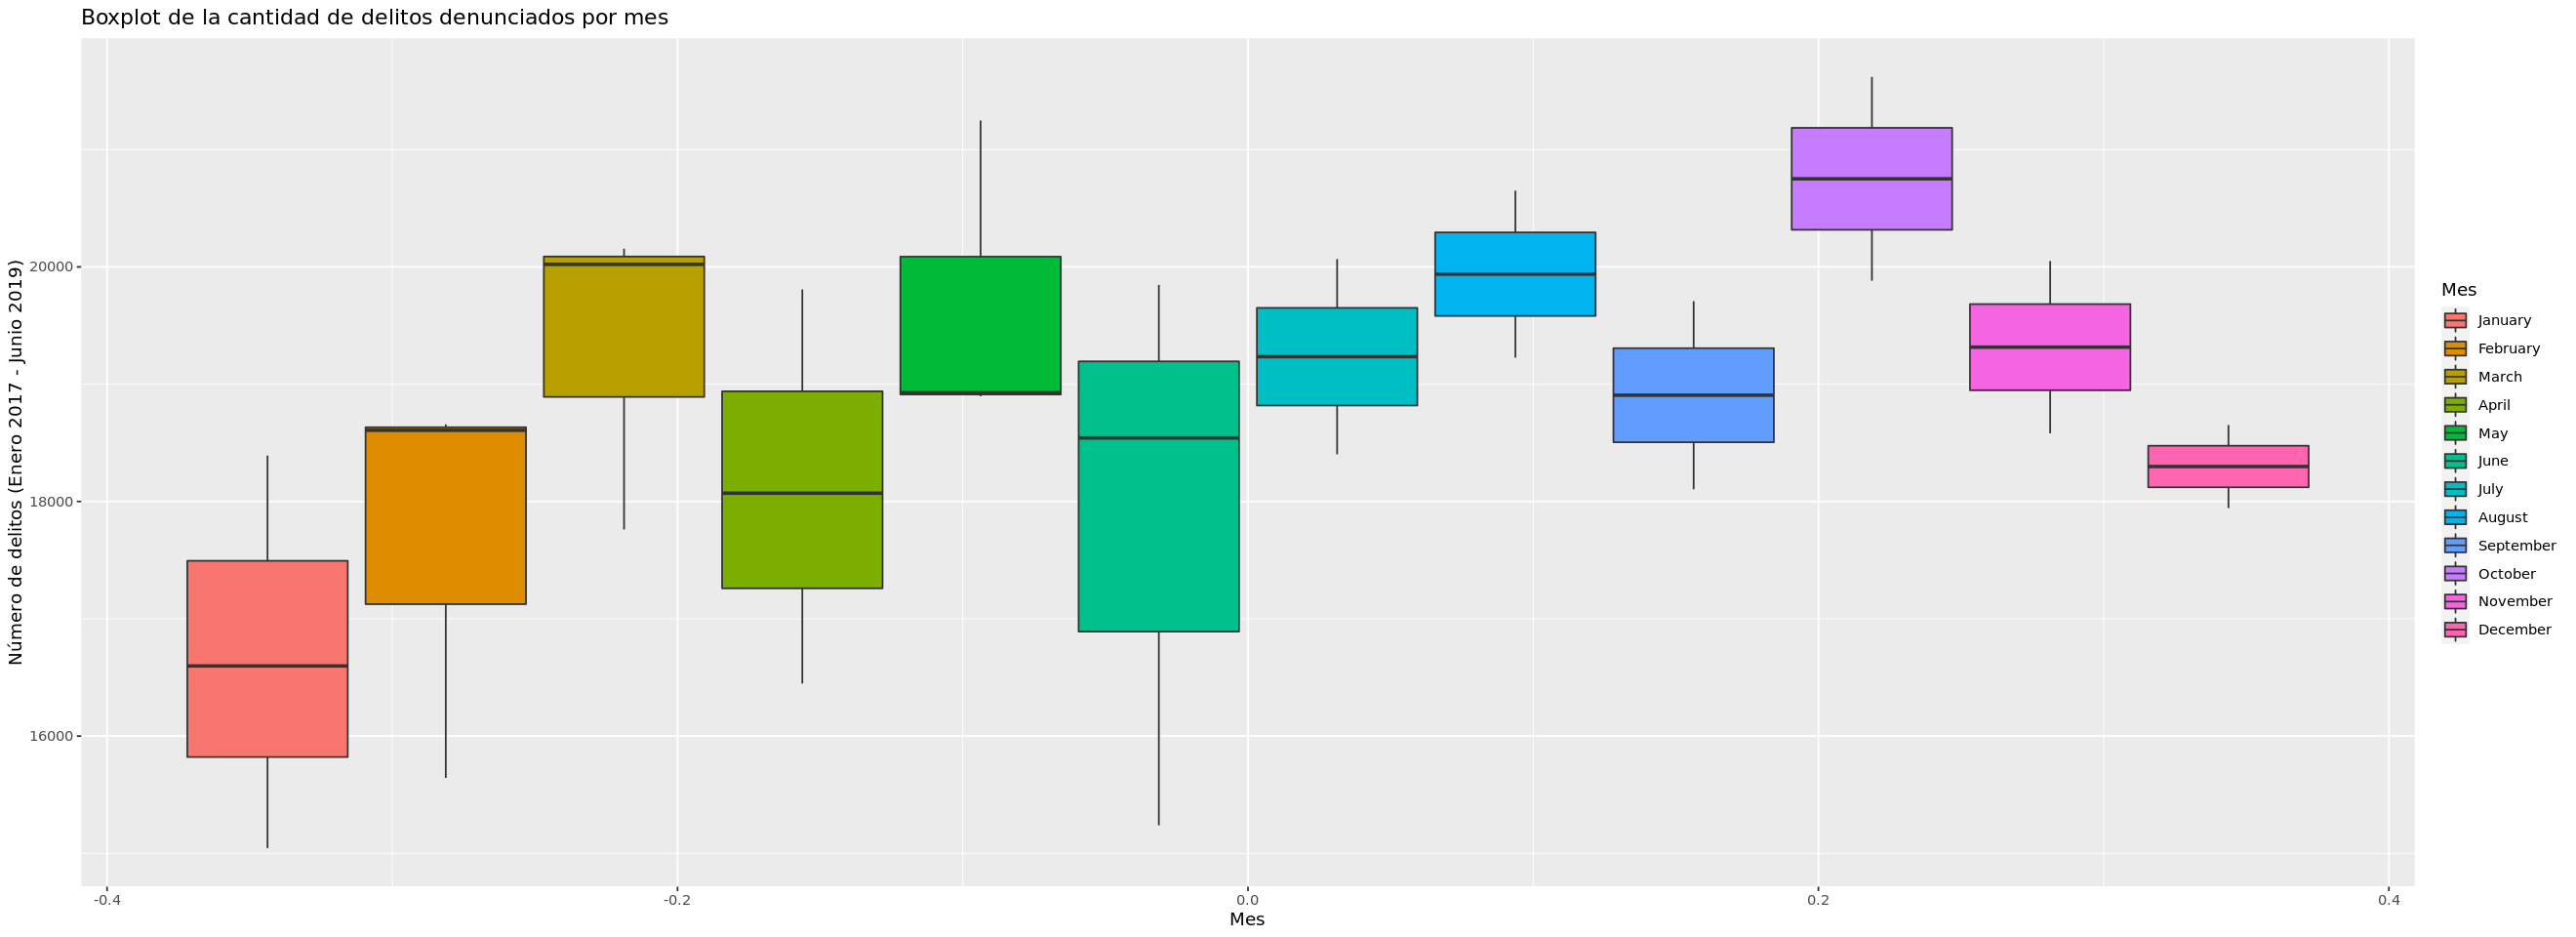

In [24]:
ggplot(d.mes,aes(n)) +
    geom_boxplot(aes(fill = mes)) +
    coord_flip() +
    labs(x = 'Número de delitos (Enero 2017 - Junio 2019)',
         y = 'Mes',
         title = 'Boxplot de la cantidad de delitos denunciados por mes',
         fill = 'Mes')

Con lo anterior se observa que el mes de _Octubre_ es el mes con mayor número de delitos, mientras que el mes con el mayor rango intercuantil es el mes de _Junio_ con un valor de $2,304$ denuncias.

Finalmente, si queremos saber si existe alguna correlación entre el número de delitos denunciados, con el indice de marginación y tamaño de la población usamos la información del _CONAPO_ del 2015, el cuál también incluye el tamaño de población. Por lo tanto se usa la tabla siguiente:

In [25]:
denuncias <- delitos %>%
    group_by(CVE_MUN,alcaldia_hechos) %>%
    tally(sort = TRUE) %>%
    inner_join(marg_index, by = 'CVE_MUN') %>%
    select(CVE_MUN, alcaldia_hechos, n, POB_TOT,IM) %>%
    rename(`Alcaldía` = alcaldia_hechos, `Delitos` = n, `Población`= POB_TOT)
denuncias

CVE_MUN,Alcaldía,Delitos,Población,IM
<dbl>,<fct>,<int>,<int>,<dbl>
9015,CUAUHTEMOC,89016,532553,-1.951
9007,IZTAPALAPA,83399,1827868,-1.627
9005,GUSTAVO A MADERO,56542,1164477,-1.728
9014,BENITO JUAREZ,50386,417416,-2.228
9016,MIGUEL HIDALGO,38128,364439,-2.131
9003,COYOACAN,37835,608479,-1.994
9010,ALVARO OBREGON,37670,749982,-1.779
9017,VENUSTIANO CARRANZA,32850,427263,-1.811
9012,TLALPAN,32148,677104,-1.738


Finalmente la matriz de correlación nos arroja lo siguiente:

In [26]:
cor(denuncias[,3:5])

,Delitos,Población,IM
Delitos,1.0000,0.71309,-0.41621
Población,0.7131,1.00000,-0.01791
IM,-0.4162,-0.01791,1.00000


Con lo cual observamos que existe una gran asociación lineal entre el tamaño de la población y el número de delitos denunciados ($0.7131$), pero no así entre el índice de marginación y el número de delitos denunciados, incluso esta es negativa ($-0.41621$), mientras que la asociación lineal entre el tamaño de la población y el indice de marginación es débil ($-0.01791$).

Lo anterior se puede apreciar en la gráfica siguiente.

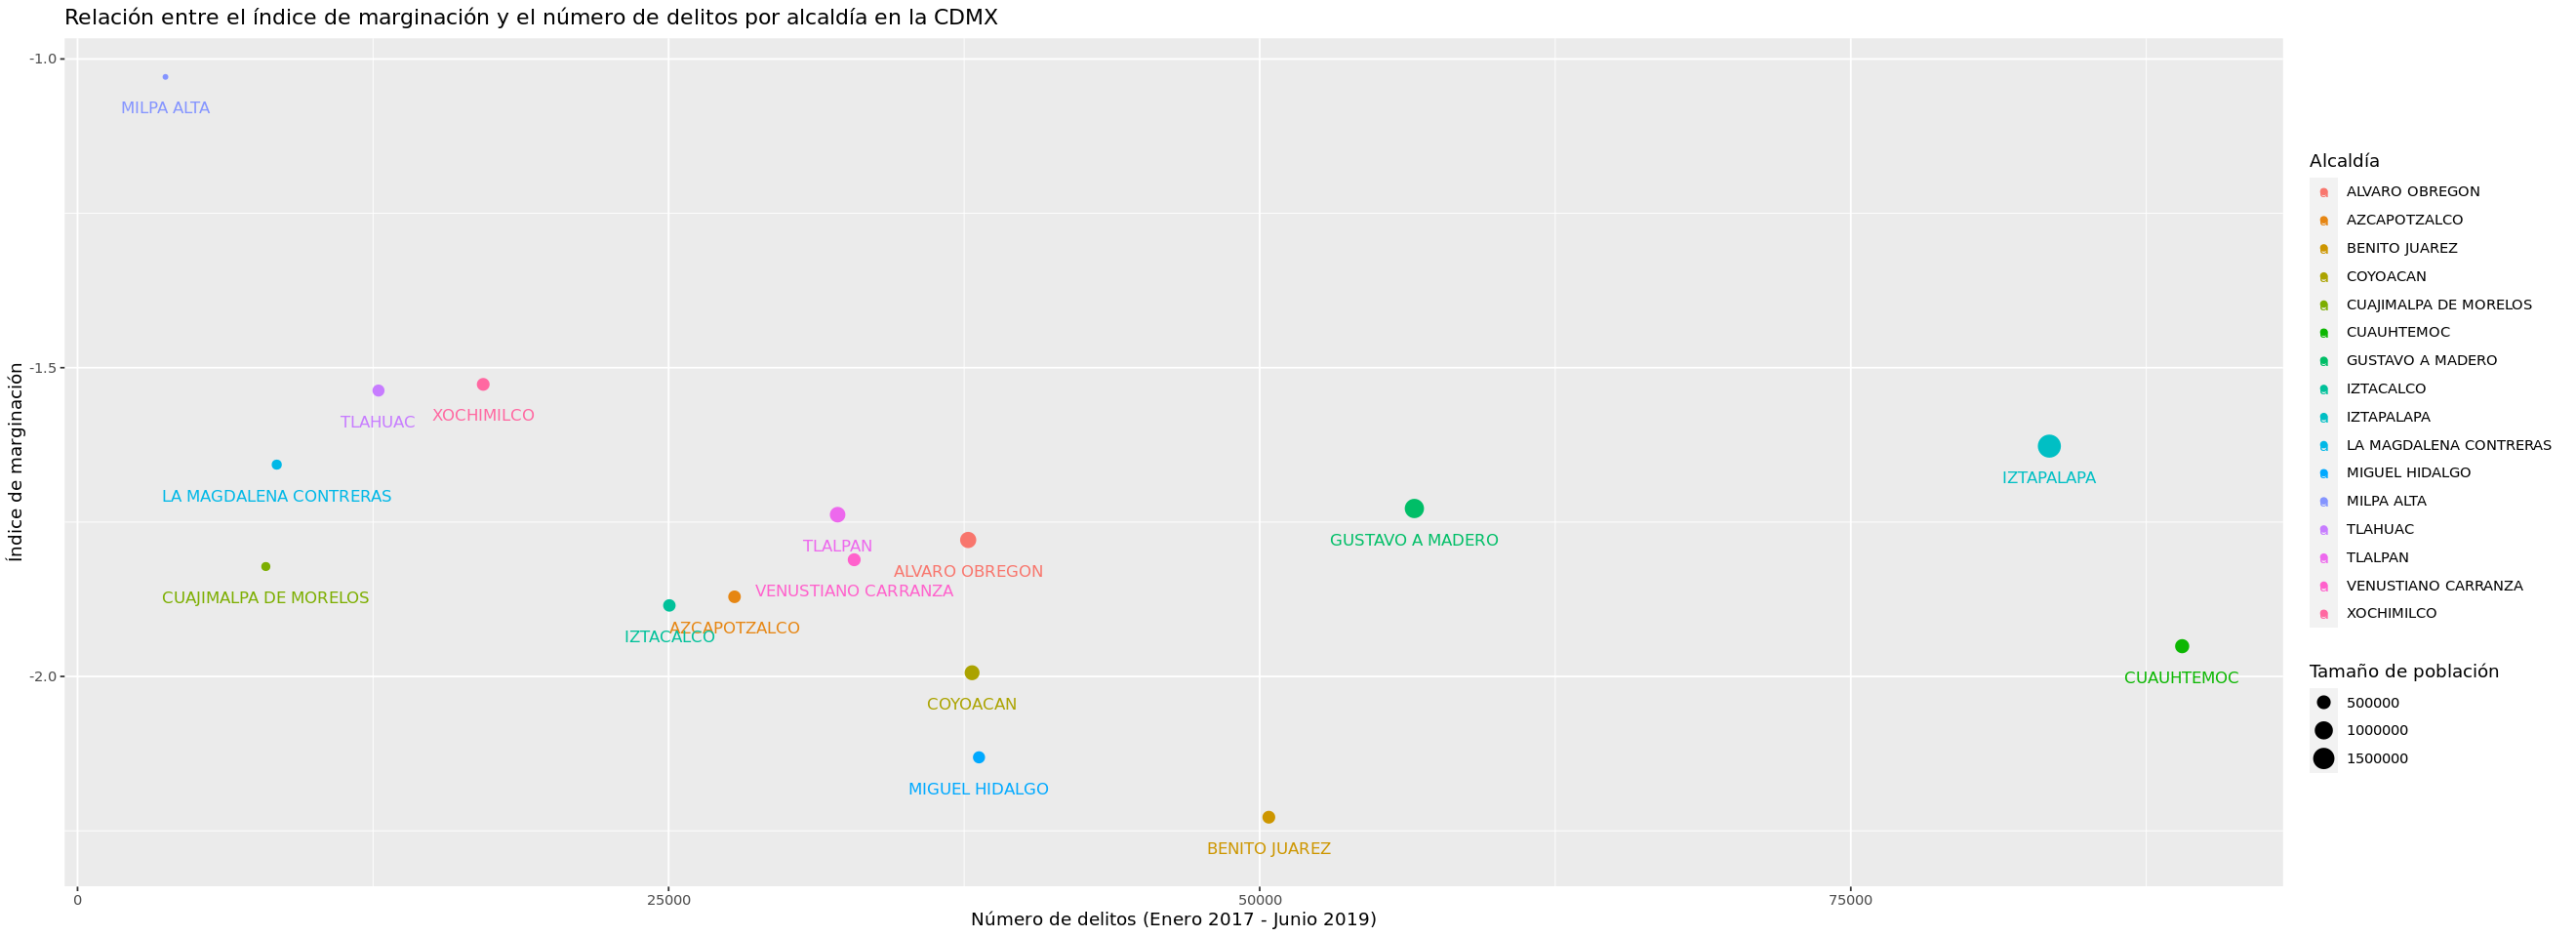

In [27]:
denuncias %>%
    ggplot(aes(x = Delitos, y = IM, color = Alcaldía, size = Población, label = Alcaldía)) +
    geom_point() +
    geom_text(aes(y = IM-0.05, label = Alcaldía), size = 3.5) +
    labs(x = 'Número de delitos (Enero 2017 - Junio 2019)',
         y = 'Índice de marginación',
         title = 'Relación entre el índice de marginación y el número de delitos por alcaldía en la CDMX',
         size = 'Tamaño de población')

## Inferencia

## Conclusiones